# Stroke Classification Process

In [1]:
###SPARK CONNECTION TO JSON FILE AND CONVERSION TO PANDAS DATAFRAME###
###IMPORT OF XML FILE (SAME DATASET AS JSON FILE) AND CONVERSION TO PANDAS DATAFRAME###

import pandas as pd
from pyspark.sql import SparkSession, types

spark = SparkSession.builder.master("local").getOrCreate()
df_json = spark.read.json('/Users/willdowdy/Desktop/Data_Options/stroke_data.json').toPandas()

with open('/Users/willdowdy/Desktop/Data_Options/stroke_data.xml', 'r') as f:
    xml_data = f.read()
    
from bs4 import BeautifulSoup as bs

column_names = set([i.name for i in bs(xml_data).find_all() if i.name not in ['body','data','html','index','row']])

df_dict = {key:[] for key in column_names}

for i in column_names:
    for x in bs(xml_data).find_all(i):
        df_dict[i].append(x.text)
        
df_xml = pd.DataFrame.from_dict(df_dict)

df_xml

,stroke,avg_glucose_level,heart_disease,residence_type,age,gender,ever_married,bmi,id,work_type,smoking_status,hypertension
0,1,228.69,1,Urban,67.0,Male,Yes,36.6,9046,Private,formerly smoked,0
1,1,202.21,0,Rural,61.0,Female,Yes,,51676,Self-employed,never smoked,0
2,1,105.92,1,Rural,80.0,Male,Yes,32.5,31112,Private,never smoked,0
3,1,171.23,0,Urban,49.0,Female,Yes,34.4,60182,Private,smokes,0
4,1,174.12,0,Rural,79.0,Female,Yes,24.0,1665,Self-employed,never smoked,1
...,...,...,...,...,...,...,...,...,...,...,...,...
5105,0,83.75,0,Urban,80.0,Female,Yes,,18234,Private,never smoked,1
5106,0,125.2,0,Urban,81.0,Female,Yes,40.0,44873,Self-employed,never smoked,0
5107,0,82.99,0,Rural,35.0,Female,Yes,30.6,19723,Self-employed,never smoked,0
5108,0,166.29,0,Rural,51.0,Male,Yes,25.6,37544,Private,formerly smoked,0


In [3]:
###TRANSFORMING BINARY CATEGORICAL VARIABLES TO BINARY (0|1) FORMAT###
###TESTING ORIGINAL COLUMNS AGAINST NEW COLUMNS TO VALIDATE CONSISTENCY OF TRANSFORMATION###

class font:
   BOLD = '\033[1m'
   END = '\033[0m'

new_ever_married = [0 if i == 'No' else 1 for i in df_xml['ever_married']]
test_ever_married = list(zip(df_xml['ever_married'],new_ever_married))[5:8]
print(font.BOLD + 'Ever_Married Test:' + font.END, test_ever_married)

new_gender = [0 if i == 'Female' else 1 for i in df_xml['gender']]
test_gender = list(zip(df_xml['gender'],new_gender))[5:8]
print(font.BOLD + 'Male_Else_Female Test:' + font.END, test_gender)

new_residence_type = [0 if i == 'Rural' else 1 for i in df_xml['residence_type']]
test_residence_type = list(zip(df_xml['residence_type'],new_residence_type))[5:8]
print(font.BOLD + 'Urban_Else_Rural Test:' + font.END, test_residence_type)

binary_dict = {'ever_married': new_ever_married, 'male_else_female': new_gender, 'urban_else_rural': new_residence_type} 
    
binary_df = pd.DataFrame(binary_dict)


Ever_Married Test: [('Yes', 1), ('Yes', 1), ('No', 0)]
Male_Else_Female Test: [('Male', 1), ('Male', 1), ('Female', 0)]
Urban_Else_Rural Test: [('Urban', 1), ('Rural', 0), ('Urban', 1)]


In [4]:
###TRANSFORMING NOMINAL CATEGORICAL VARIABLES TO BINARY (0|1) FORMAT###
###TESTING ORIGINAL COLUMNS AGAINST NEW COLUMNS TO VALIDATE CONSISTENCY###

df_smoking_status = pd.get_dummies(df_xml.smoking_status)
test_smoking_status = pd.concat([df_xml['smoking_status'],df_smoking_status], axis = 'columns')
print(font.BOLD + 'Smoking_Status Test\n' + font.END, test_smoking_status)

df_work_type = pd.get_dummies(df_xml.work_type)
test_work_type = pd.concat([df_xml['work_type'],df_work_type], axis = 'columns')
print(font.BOLD + '\nWork_Type Test\n' + font.END, test_work_type)


Smoking_Status Test
        smoking_status  Unknown  formerly smoked  never smoked  smokes
0     formerly smoked        0                1             0       0
1        never smoked        0                0             1       0
2        never smoked        0                0             1       0
3              smokes        0                0             0       1
4        never smoked        0                0             1       0
...               ...      ...              ...           ...     ...
5105     never smoked        0                0             1       0
5106     never smoked        0                0             1       0
5107     never smoked        0                0             1       0
5108  formerly smoked        0                1             0       0
5109          Unknown        1                0             0       0

[5110 rows x 5 columns]

Work_Type Test
           work_type  Govt_job  Never_worked  Private  Self-employed  children
0           Private

In [5]:
###RENAMING VAGUE COLUMNS GENERATED FROM TRANSFORMATIONS###

df_smoking_status.rename(columns = {'Unknown':'smoke_unknown'}, inplace = True)
df_work_type.rename(columns = {'Private':'private_work','children':'children_work'}, inplace = True)

In [6]:
###CONCATENATING REMAINING COLUMNS AND NEW COLUMNS###
###CONVERTING EACH COLUMN TO DATA TYPE'FLOAT' AND DROPPING RECORDS WITH NULL VALUES(4% OF RECORDS)###
###DROPPING I.D. COLUMN FOR MODELING PURPOSES###

new_df = df_xml[['bmi','age','hypertension','id','heart_disease','stroke','avg_glucose_level']]
df = pd.concat([new_df,binary_df,df_smoking_status,df_work_type], axis = 'columns')
df = df.apply(pd.to_numeric).astype(float).dropna()
df.drop('id', axis = 1, inplace = True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4909 entries, 0 to 5109
Data columns (total 18 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   bmi                4909 non-null   float64
 1   age                4909 non-null   float64
 2   hypertension       4909 non-null   float64
 3   heart_disease      4909 non-null   float64
 4   stroke             4909 non-null   float64
 5   avg_glucose_level  4909 non-null   float64
 6   ever_married       4909 non-null   float64
 7   male_else_female   4909 non-null   float64
 8   urban_else_rural   4909 non-null   float64
 9   smoke_unknown      4909 non-null   float64
 10  formerly smoked    4909 non-null   float64
 11  never smoked       4909 non-null   float64
 12  smokes             4909 non-null   float64
 13  Govt_job           4909 non-null   float64
 14  Never_worked       4909 non-null   float64
 15  private_work       4909 non-null   float64
 16  Self-employed      4909 

In [7]:
###DEFINING FUNCTIONS USED TO TEST MODEL TYPES###

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.naive_bayes import GaussianNB

def Logistic_Regression(X, y, iterations, cross_val, title):
    LR = LogisticRegression(max_iter = iterations)
    y_pred = cross_val_predict(LR, X, y, cv = cross_val)
    classification = classification_report(y, y_pred)
    auc = roc_auc_score(y, y_pred)
    print(font.BOLD + title + '\n' + font.END)
    print(classification)
    print('AUC Score')
    print(str(auc) + '\n')

def Random_Forest(X, y, estimators, cross_val, title):
    RF = RandomForestClassifier(n_estimators = estimators)
    y_pred = cross_val_predict(RF, X, y, cv = cross_val)
    classification = classification_report(y, y_pred)
    auc = roc_auc_score(y, y_pred)
    print(font.BOLD + title + '\n' + font.END)
    print(classification)
    print('AUC Score')
    print(str(auc) + '\n')
    
def Naive_Bayes(X, y, cross_val, title):
    gnb = GaussianNB()
    y_pred = cross_val_predict(gnb, X, y, cv = cross_val)
    classification = classification_report(y, y_pred)
    auc = roc_auc_score(y, y_pred)
    print(font.BOLD + title + '\n' + font.END)
    print(classification)
    print('AUC Score')
    print(str(auc) + '\n')


In [8]:
###RUNNING PROTOTYPE MODELS TO GAUGE STATUS PRIOR TO DATA EXPLORATION/FEATURE SELECTION METHODS###

X = df.drop('stroke', axis = 1)
y = df['stroke']

Logistic_Regression(X, y, 800, 10, 'Logistic Regression Prototype Model')
Random_Forest(X, y, 50, 10, 'Random Forest Prototype Model')
Naive_Bayes(X, y, 10, 'Naive Bayes Prototype Model')

Logistic Regression Prototype Model

              precision    recall  f1-score   support

         0.0       0.96      1.00      0.98      4700
         1.0       0.50      0.00      0.01       209

    accuracy                           0.96      4909
   macro avg       0.73      0.50      0.49      4909
weighted avg       0.94      0.96      0.94      4909

AUC Score
0.5022859615188842

Random Forest Prototype Model

              precision    recall  f1-score   support

         0.0       0.96      1.00      0.98      4700
         1.0       0.18      0.01      0.02       209

    accuracy                           0.96      4909
   macro avg       0.57      0.50      0.50      4909
weighted avg       0.92      0.96      0.94      4909

AUC Score
0.5038272421867047

Naive Bayes Prototype Model

              precision    recall  f1-score   support

         0.0       0.99      0.52      0.69      4700
         1.0       0.08      0.91      0.14       209

    accuracy             

In [9]:
###NORMALIZING FEATURES OF VARIED SCALES/MAGNITUDES - SETTING SCALE BETWEEN 0 AND 1### 

from sklearn.preprocessing import MinMaxScaler

scale_df = df[['bmi','age','avg_glucose_level']]
scale_df = pd.DataFrame(MinMaxScaler().fit_transform(scale_df), columns = ['bmi_scale','age_scale','glucose_scale'])
scale_df.reset_index(drop = True, inplace = True)
df.reset_index(drop = True, inplace = True)
df_2 = pd.concat([scale_df,df], axis = 'columns')
df_2.drop('avg_glucose_level', axis = 1, inplace = True)
df_2.drop('age', axis = 1, inplace = True)
df_2.drop('bmi', axis = 1, inplace = True)
df_2.head()

,bmi_scale,age_scale,glucose_scale,hypertension,heart_disease,stroke,ever_married,male_else_female,urban_else_rural,smoke_unknown,formerly smoked,never smoked,smokes,Govt_job,Never_worked,private_work,Self-employed,children_work
0,0.301260,0.816895,0.801265,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.254296,0.975586,0.234512,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.276060,0.597168,0.536008,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
3,0.156930,0.963379,0.549349,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.214204,0.987793,0.605161,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


Before Downsampling:
Percentage of records with a target value of "1": 4.26%
Goal: 30%



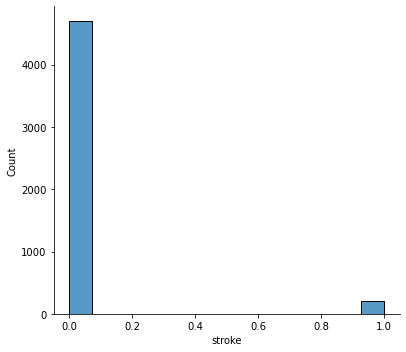

In [10]:
###GAUGING TARGET DISTRIBUTION TO DETERMINE NEED FOR DOWNSAMPLING###

import seaborn as sb
import matplotlib.pyplot as plt
import numpy as np
from sklearn.utils import resample

df_majority = df_2[df_2.stroke==0]
df_minority = df_2[df_2.stroke==1]

print(font.BOLD + 'Before Downsampling:' + font.END)

print('Percentage of records with a target value of "1": ' + str(round(len(df_minority.index)/len(df_2.index)*100,2)) + '%')
print('Goal: 30%\n')
print(sb.displot(df_2, x = 'stroke', height = 5, aspect = 1.15))


After Downsampling:
Percentage of records with a target value of "1": 30.0%



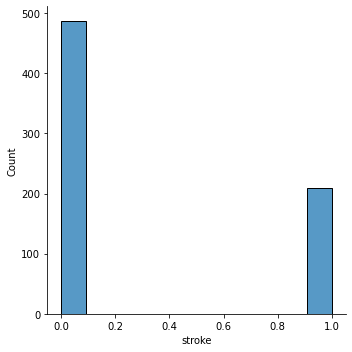

In [11]:
###DOWNSAMPLING DATASET###

cmd = resample(df_majority, replace=False, n_samples=487) 
df_down = pd.concat([df_minority, cmd])

print(font.BOLD + 'After Downsampling:' + font.END)
print('Percentage of records with a target value of "1": ' + str(round(len(df_minority.index)/len(df_down.index)*100,1)) + '%\n')
print(sb.displot(df_down, x = 'stroke'))


Correlation Heatmap (Absolute Values)


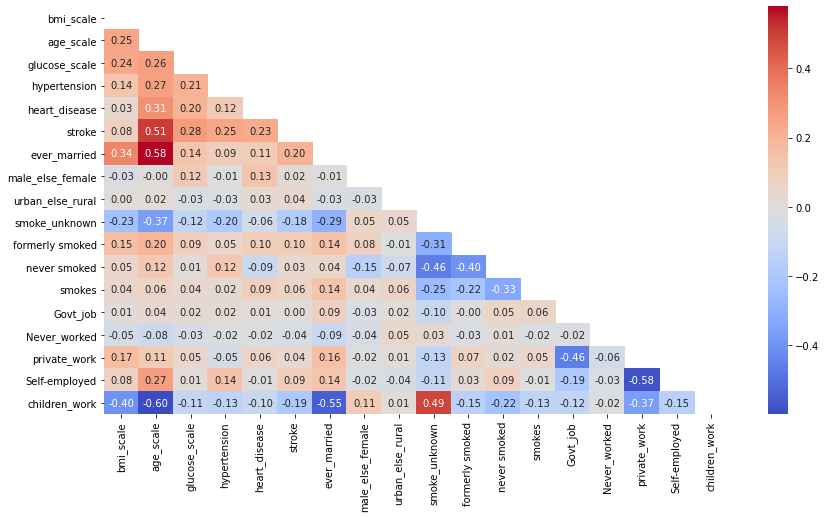

In [12]:
###CHECKING CORRELATION OF TARGET WITH FEATURES###
###CHECKING FOR MULTICOLLINEARITY AMONG FEATURES###

print(font.BOLD + 'Correlation Heatmap (Absolute Values)' + font.END)
matrix = np.triu(df_down.corr())
plt.figure(figsize=(14,7.5))
sb.heatmap(df_down.corr(), annot=True, mask = matrix, cmap = 'coolwarm', fmt = '.2f');

In [13]:
###REMOVING COLUMNS WITH MULTICOLLINEARITY TO MINIMIZE REDUNDANT INFORMATION BEING FED TO MODEL###

df_down.drop('smoke_unknown', axis = 1, inplace = True)
df_down.drop('ever_married', axis = 1, inplace = True)
df_down.drop('children_work', axis = 1, inplace = True)

Feature Importance Scores


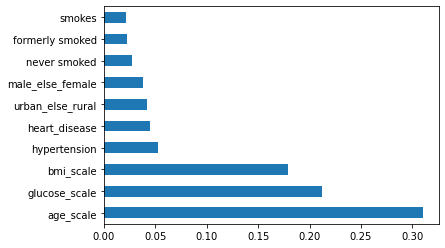

Chi-Square Scores
            Feature      Score
3      hypertension  35.628446
4     heart_disease  33.575465
1         age_scale  21.865345
2     glucose_scale  11.213540
7   formerly smoked   5.945081
13    Self-employed   4.886955
9            smokes   2.098836
11     Never_worked   0.858316
8      never smoked   0.515032
12     private_work   0.467580


In [14]:
###MEASURING FEATURE IMPORTANCE SCORES AND CHI-SQ SCORES RELATIVE TO TARGET###
###HIGH CHI-SQ INDICATES HYPOTHESIS OF INDEPENDENCE IS INCORRECT###
###PUT MORE SIMPLY, HIGHER CHI-SQ MEANS STRONGER RELATION TO TARGET###

from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

X_explore = df_down.drop('stroke', axis = 1)
y_explore = df_down['stroke']
print(font.BOLD + 'Feature Importance Scores')
pd.Series(ExtraTreesClassifier().fit(X_explore,y_explore).feature_importances_, index=X_explore.columns).nlargest(10).plot(kind='barh')
plt.show()

featureScores = pd.concat([pd.DataFrame(X_explore.columns),pd.DataFrame(SelectKBest(score_func=chi2, k='all').fit(X_explore,y_explore).scores_)],axis=1)
featureScores.columns = ['Feature','Score']  
print(font.BOLD + 'Chi-Square Scores' + font.END)
print(featureScores.nlargest(10,'Score'))

In [15]:
###COMPILING FEATURES WORTH EXPLORING FROM CORRELATION TEST, FEATURE IMPORTANCE, AND CHI-SQ###

test_features = ['heart_disease','hypertension','age_scale','glucose_scale','formerly smoked','Self-employed',
                'bmi_scale','urban_else_rural','male_else_female']

In [16]:
###RUNNING MODELS WITH IDENTIFIED FEATURES###
###IDENTIFYING MODEL WORTH OPTIMIZING FURTHER###
###AMONG METRICS, LACK OF IDENTIFYING AN INDIVIDUAL LIKELY TO HAVE A STROKE IS MOST NEGATIVELY CONSEQUENTIAL###
###PRIORITY WILL BE GIVEN TO RECALL AMONG ONES###

X = df_down[test_features]
y = df_down['stroke']

Logistic_Regression(X, y, 800, 10, 'Logistic Regression Model')
Random_Forest(X, y, 100, 10, 'Random Forest Model')
Naive_Bayes(X, y, 10, 'Naive Bayes Model')


Logistic Regression Model

              precision    recall  f1-score   support

         0.0       0.81      0.88      0.85       487
         1.0       0.66      0.53      0.59       209

    accuracy                           0.78       696
   macro avg       0.74      0.70      0.72       696
weighted avg       0.77      0.78      0.77       696

AUC Score
0.7046363341618933

Random Forest Model

              precision    recall  f1-score   support

         0.0       0.82      0.86      0.84       487
         1.0       0.63      0.55      0.59       209

    accuracy                           0.77       696
   macro avg       0.72      0.71      0.71       696
weighted avg       0.76      0.77      0.76       696

AUC Score
0.7063311161981863

Naive Bayes Model

              precision    recall  f1-score   support

         0.0       0.82      0.85      0.83       487
         1.0       0.62      0.56      0.59       209

    accuracy                           0.76       696
 

In [17]:
###OPTIMIZING NAIVE BAYES MODEL###
###ITERATING THROUGH EVERY COMBINATION OF 4 OR MORE IDENTIFIED FEATURES###
###END RESULT PROVIDES STRONGEST COMBINATION OF RECALL/PRECISION AMONG ONES (CROSS VALIDATION PERFORMED THROUGHOUT)###

import itertools
test = []
for i in range(0, len(test_features)+1):
    for subset in itertools.combinations(test_features, i):
        if len(subset) >= 4:
            test.append(list(subset))
            
print(font.BOLD + 'Number of combinations:' + font.END, str(len(test)) + '\n')

value = 0 

for i in range(len(test)):
    X = df_down[test[i]]
    y = df_down['stroke']
    gnb = GaussianNB()
    y_pred = cross_val_predict(gnb, X, y, cv = 10)
    classification = classification_report(y, y_pred, output_dict = True)
    recall = classification['1.0']['recall']
    precision = classification['1.0']['precision']
    test_val = (recall*1.1) + (precision)
    current = []
    if test_val > value:
        value = test_val
        current.append(value)
        current.append(list(X))
        features = list(X)
        print(current)

print(font.BOLD + '\nFeature set with strongest model:' + font.END, str(features))

Number of combinations: 382

[1.2048582995951418, ['heart_disease', 'hypertension', 'age_scale', 'glucose_scale']]
[1.2308471714044469, ['hypertension', 'age_scale', 'glucose_scale', 'formerly smoked']]
[1.250135648399349, ['age_scale', 'glucose_scale', 'formerly smoked', 'bmi_scale']]
[1.263785110444505, ['age_scale', 'glucose_scale', 'Self-employed', 'urban_else_rural']]
[1.2718535469107553, ['age_scale', 'glucose_scale', 'bmi_scale', 'urban_else_rural']]
[1.313168905527417, ['age_scale', 'formerly smoked', 'Self-employed', 'urban_else_rural']]
[1.3152759948652117, ['age_scale', 'formerly smoked', 'bmi_scale', 'urban_else_rural']]
[1.3598657136668832, ['age_scale', 'formerly smoked', 'urban_else_rural', 'male_else_female']]

Feature set with strongest model: ['age_scale', 'formerly smoked', 'urban_else_rural', 'male_else_female']


In [18]:
###RUNNING FINAL MODEL###

X = df_down[features]
y = df_down['stroke']

Naive_Bayes(X, y, 10, 'Naive Bayes Model')

Naive Bayes Model

              precision    recall  f1-score   support

         0.0       0.86      0.80      0.83       487
         1.0       0.60      0.69      0.64       209

    accuracy                           0.77       696
   macro avg       0.73      0.75      0.73       696
weighted avg       0.78      0.77      0.77       696

AUC Score
0.7462739357260053

